In [1]:
import pandas as pd 
import numpy as np

from sklearn.base import  BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Normalizer, FunctionTransformer, StandardScaler, LabelBinarizer, FunctionTransformer, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA, SparsePCA
from sklearn.cross_decomposition import PLSRegression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import plot_roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from itertools import  product
from scipy.linalg import LinAlgError

import scipy
from scipy.stats import f_oneway, ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("ticks")

data_path = "./CART_tables_25Nov2022/"

%matplotlib inline

# ML utils

In [216]:
class ColumnsIdentifier(BaseEstimator, TransformerMixin):
    def __init__(self, columns_lst):
        self.columns_lst = columns_lst
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        Xt = X.copy()
        Xt = Xt.loc[:,self.columns_lst]
        return Xt
    
class RAFilter(BaseEstimator, TransformerMixin):
    def __init__(self, capval = 5e-2):
        self._f_list = []
        self.capval = capval
        pass

    def fit(self, X,y=None, modemap = []):
        X_t = X.copy()
        X_t = 100 * X_t.div(X_t.sum(axis=1), axis=0)
        self._f_list = [i for i in range(X_t.shape[1]) if X_t.iloc[:,i].max() > self.capval ]
        return self
    
    def transform(self, X, y = None):
        X_t = X.iloc[:,self._f_list].copy()
        X_t[X_t < self.capval] = self.capval
        X_t = 100 * X_t / X_t.values.sum(axis=1,keepdims = True)
        return X_t


    def fit_transform(self, X, y = None, modemap = []):
        self = self.fit(X, y, modemap)
        Xt = self.transform(X, y)
        return Xt
    
class PLSRegressionWrapper(PLSRegression):

    def transform(self, X):
        return super().transform(X)

    def fit_transform(self, X, Y):
        return self.fit(X,Y).transform(X)
    
    
def clinical_pipeline_gs(clinical_colnames):
    return Pipeline([("fset", ColumnsIdentifier(clinical_colnames)),
                     ('log',FunctionTransformer(lambda x: np.log10(1 + x))),
                     ('SS',StandardScaler(with_std=False))
                    ])

def taxa_pipeline_gs(taxa_colnames):
    return Pipeline([("fset", ColumnsIdentifier(taxa_colnames)),
                     ('raf', RAFilter()),
                     ('log',FunctionTransformer(lambda x: np.log10(1 + x))),
                     ('SS', StandardScaler(with_std=False))
                    ])


param_grid_clf = {
    'clf__C': np.linspace(5e-2,2e-0, 5),
    'clf__l1_ratio':np.logspace(-1,0,5),
    "funion__taxa__raf__capval": np.linspace(1e-3,1e-2, 5),
}

# All subjects


## Read data

- Sub-setting the samples based on: "-21 <= sampleDay_sample" < 1 
- Target features to predict:
   * CR at day 180 (indicated in the "CART_table_response.xlsx" table)
   * Survival (or "dead") at day 180 (indicated in the "CART_table_response.xlsx" table)
   * Early progression ("Progression_early" indicated in the "CART_table_patients.xlsx" table)

In [256]:
# reading and subsetting patients list
stool_table_habx = pd.read_excel(f"{data_path}/CART_table_stool.xlsx"
                               , engine='openpyxl')\
                                .query("sampleDay_sample < 1")\
                                .query("sampleDay_sample >= -21")
#                                 .query("Basal_no_HighRisk_sample == True")

subs = # Here is given a set indicating patients to be excluded in accordance with the exclusion criteria  # 

_sid_subset_habx = stool_table_habx['subjectID'].unique()
_sid_subset_habx = [s for s in _sid_subset_habx if s not in subs]


patients_table_habx = pd.read_excel(f"{data_path}/CART_table_patients.xlsx"
                               , engine='openpyxl')\
                                .query(f"subjectID in @_sid_subset_habx")
                                

response_table_habx = pd.read_excel(f"{data_path}/CART_table_response.xlsx"
                               , engine='openpyxl')\
                                .query('Day == 180')\
                                .query('subjectID in @_sid_subset_habx')\
                                .dropna(subset = ['Response'])

patients_table_habx = patients_table_habx.loc[patients_table_habx['subjectID'].isin(response_table_habx['subjectID'])]
response_table_habx = response_table_habx.loc[response_table_habx['subjectID'].isin(patients_table_habx['subjectID'])]
stool_table_habx = stool_table_habx.loc[stool_table_habx['subjectID'].isin(patients_table_habx['subjectID'])]


taxa_table_habx = stool_table_habx.loc[:,['subjectID','stool_sample_id']].merge(pd.read_excel(f"{data_path}/CART_table_taxa.xlsx", engine='openpyxl'), how = 'left')\
                    .groupby(['subjectID']).apply(lambda x:x.iloc[:,1:].mean())



stool_table_habx = stool_table_habx.loc[stool_table_habx['subjectID'].isin(taxa_table_habx.index)]
patients_table_habx = patients_table_habx.loc[patients_table_habx['subjectID'].isin(taxa_table_habx.index)]

_sid_subset_habx = stool_table_habx['subjectID'].unique()
_sid_subset_habx = [s for s in _sid_subset_habx if s not in subs]

patients_table_habx = patients_table_habx.query(f"subjectID in @_sid_subset_habx")

taxa_table_habx = taxa_table_habx.loc[patients_table_habx['subjectID']]

## Summarize metadata for reporting

In [257]:
meta_stats = patients_table_habx.set_index('subjectID').loc[:,['Country']]\
                .join(stool_table_habx.loc[:,['Basal_no_HighRisk_sample','subjectID']].drop_duplicates().set_index('subjectID'))\
                .join(response_table_habx.assign(CR180 = lambda df: df['Response'].apply(lambda x: 'CR' if x =='CR' else 'noCR'))\
                        .loc[:,['subjectID','CR180']].set_index('subjectID').sort_index())



country_stats = meta_stats.groupby(['Country']).size().rename('n_subjects_per_country').reset_index()


country_abx_stats = meta_stats.groupby(['Country','Basal_no_HighRisk_sample']).size().rename('n_subjects_per_risk').reset_index()



country_abx_cr_stats = meta_stats.groupby(['Country','Basal_no_HighRisk_sample','CR180']).size().rename('n_subjects_per_response').reset_index()


stats_indcol = ['Country','n_subjects_per_country','Basal_no_HighRisk_sample','n_subjects_per_risk','CR180','n_subjects_per_response','subjectID']

stats_disp = country_stats.merge(country_abx_stats).merge(country_abx_cr_stats).merge(meta_stats.reset_index()).set_index(stats_indcol).sort_index()

stats_disp.to_excel("CR180_all_subjects_excluding_6patients_stats.xlsx")


## Test - train split

In [258]:
train_patients_habx = patients_table_habx.query('Country == "Germany"')['subjectID'].unique().tolist()
test_patients_habx = patients_table_habx.query('Country == "US"')['subjectID'].unique().tolist()

## Set X (input) and y (response)

In [259]:
# X
patients_x_habx = patients_table_habx.set_index(['subjectID']).loc[:,['Gender','Age']]
patients_x_habx['gender_m'] = 1*(patients_x_habx['Gender'] == 'm')
patients_x_habx['gender_f'] = 1*(patients_x_habx['Gender'] == 'f')
patients_x_habx.drop('Gender', axis=1,inplace = True)

X_all_habx = pd.concat([taxa_table_habx, patients_x_habx], axis=1)
X_atrain_habx, X_atest_habx = X_all_habx.loc[train_patients_habx].copy(), X_all_habx.loc[test_patients_habx].copy()

taxa_cols_habx = taxa_table_habx.columns.tolist()
clinical_cols_habx = patients_x_habx.columns.tolist()


# y
cr_y_habx = 1 * (response_table_habx.set_index('subjectID')['Response'] == 'CR').loc[X_all_habx.index]
cr_y_train_habx, cr_y_test_habx = cr_y_habx.loc[train_patients_habx].copy(), cr_y_habx.loc[test_patients_habx].copy()

## Train

### Initial CV for best hyperparameters

In [260]:
feature_extractors = []



feature_extractors.append(('clinical', clinical_pipeline_gs(clinical_cols_habx)))



feature_extractors.append((f"taxa", taxa_pipeline_gs(taxa_cols_habx)))


union = FeatureUnion(feature_extractors, n_jobs=None)


clf_pipe = Pipeline([
    ('funion', union),
    ('clf', LogisticRegression(penalty='elasticnet',max_iter=500, fit_intercept=True, solver='saga'))
])




gscv = GridSearchCV(clf_pipe, param_grid_clf, verbose=3, n_jobs=10
                    ,scoring='roc_auc',return_train_score=True)
gscv.fit(X_atrain_habx, cr_y_train_habx)

print(gscv.best_score_)
print(gscv.best_params_)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
0.6356666666666667
{'clf__C': 2.0, 'clf__l1_ratio': 0.1, 'funion__taxa__raf__capval': 0.001}


### Prune inputs based on top coefficients

In [261]:
best_est = gscv.best_estimator_
fu_best = best_est['funion']


columns_best = fu_best.transformer_list[0][-1]['fset'].columns_lst.copy()
columns_best += [f for i,f in enumerate(fu_best.transformer_list[1][-1]['fset'].columns_lst.copy()) if i in fu_best.transformer_list[1][-1]['raf']._f_list]

selected_columns_ser = pd.Series({f:c for f,c in zip(columns_best, gscv.best_estimator_['clf'].coef_[0,:])})
selected_columns_ser.sort_values().to_csv("./deterministic_results/CR180_WithHighRiskABX_elasticnet_train_coefficients.csv")
selected_columns = (selected_columns_ser[selected_columns_ser.abs() > 0]**2).nlargest( 30 ).index.tolist()
selected_taxa = [f for f in selected_columns if f in taxa_cols_habx]
selected_clinical = [f for f in selected_columns if f in clinical_cols_habx]

print("selected_taxa:",len(selected_taxa))
print("selected_clinical:",len(selected_clinical))
print(*selected_columns,sep="\n")
len(selected_columns)

selected_taxa: 30
selected_clinical: 0
Bacteroides_eggerthii
Ruminococcus_lactaris
Bacteroides_stercoris
Eubacterium_sp_CAG_180
Roseburia_faecis
Lactobacillus_amylovorus
Bacteroides_fragilis
Bacteroides_thetaiotaomicron
Erysipelatoclostridium_ramosum
Akkermansia_muciniphila
Anaerostipes_hadrus
Fusicatenibacter_saccharivorans
Faecalibacterium_prausnitzii
Eubacterium_sp_CAG_38
Bacteroides_dorei
Blautia_obeum
Clostridium_innocuum
Escherichia_coli
Alistipes_finegoldii
Coprococcus_comes
Lactobacillus_gasseri
Bacteroides_cellulosilyticus
Ruminococcus_gnavus
Streptococcus_salivarius
Roseburia_inulinivorans
Roseburia_intestinalis
Eubacterium_eligens
Lactobacillus_brevis
Intestinibacter_bartlettii
Bifidobacterium_pseudocatenulatum


30

### Set up model with optimal hyper params and reduced input

In [262]:
best_taxa_raf_params = fu_best.transformer_list[1][-1]['raf'].get_params().copy()
best_clf_params = best_est['clf'].get_params().copy()
# best_clf_params['C'] = best_clf_params['C']*10

feature_extractors2 = []

if len(selected_clinical) > 0:
    prep_clinical = clinical_pipeline_gs(selected_clinical)
    feature_extractors2.append(('clinical', prep_clinical))



prep_taxa = Pipeline([("fset", ColumnsIdentifier(taxa_cols_habx)),
                      ('raf', RAFilter(**best_taxa_raf_params)),
                      ('fset2', ColumnsIdentifier(selected_taxa)),
                      ('log',FunctionTransformer(lambda x: np.log10(1 + x))),
                      ('SS', StandardScaler(with_std=False)),
                     ])

feature_extractors2.append(('taxa',prep_taxa))

union2 = FeatureUnion(feature_extractors2)
clf_pipe2 = Pipeline([
    ('prep',union2),
    ('clf', LogisticRegression(**best_clf_params))
])


### refit

In [263]:
clf_pipe2.fit(X_atrain_habx, cr_y_train_habx)

Pipeline(steps=[('prep',
                 FeatureUnion(transformer_list=[('taxa',
                                                 Pipeline(steps=[('fset',
                                                                  ColumnsIdentifier(columns_lst=['Methanobrevibacter_smithii',
                                                                                                 'Methanosphaera_stadtmanae',
                                                                                                 'Candidatus_Methanomassiliicoccus_intestinalis',
                                                                                                 'Actinobaculum_sp_oral_taxon_183',
                                                                                                 'Actinomyces_graevenitzii',
                                                                                                 'Actinomyces_naeslundii',
                                                                 

## evaluate model

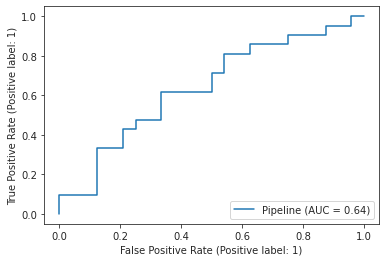

ROC AUC: 0.638888888888889
confusion matrix:
[[16  8]
 [11 10]]


In [264]:
test_roc = plot_roc_curve(clf_pipe2, X_atest_habx,cr_y_test_habx  )
plt.show()

print('ROC AUC:',str(test_roc.roc_auc))
print('confusion matrix:')
print(confusion_matrix(cr_y_test_habx, clf_pipe2.predict(X_atest_habx)))

roc_test = pd.DataFrame(dtype=np.float64)
roc_test['FPR'] = test_roc.fpr
roc_test['TPR'] = test_roc.tpr
roc_test['auc'] = str(test_roc.roc_auc)

habx_roc_df = pd.DataFrame([roc_test['FPR'],roc_test['TPR']]).T
habx_roc_df.to_csv('./deterministic_results/CR180_WithHighRiskABX_elasticnet_test_roc_curve.csv', index=False)

# No high-risk abx subjects

## Read data

- Sub-setting the samples based on two criteria: "-21 <= sampleDay_sample" < 1  AND "Basal_no_HighRisk_sample" ==  True (meaning no high-risk Abx in the last 14 days before infusion). 
- Target features to predict:
   * CR at day 180 (indicated in the "CART_table_response.xlsx" table)
   * Survival (or "dead") at day 180 (indicated in the "CART_table_response.xlsx" table)
   * Early progression ("Progression_early" indicated in the "CART_table_patients.xlsx" table)

In [229]:
# reading and subsetting patients list
stool_table_nohrabx = pd.read_excel(f"{data_path}/CART_table_stool.xlsx"
                               , engine='openpyxl')\
                                .query("sampleDay_sample < 1")\
                                .query("sampleDay_sample >= -21")\
                                .query("Basal_no_HighRisk_sample == True")




_sid_subset_nohrabx = stool_table_nohrabx['subjectID'].unique()
_sid_subset_nohrabx = [s for s in _sid_subset_nohrabx if s not in subs]


patients_table_nohrabx = pd.read_excel(f"{data_path}/CART_table_patients.xlsx"
                               , engine='openpyxl')\
                                .query(f"subjectID in @_sid_subset_nohrabx")
                                

response_table_nohrabx = pd.read_excel(f"{data_path}/CART_table_response.xlsx"
                               , engine='openpyxl')\
                                .query('Day == 180')\
                                .query('subjectID in @_sid_subset_nohrabx')\
                                .dropna(subset = ['Response'])

patients_table_nohrabx = patients_table_nohrabx.loc[patients_table_nohrabx['subjectID'].isin(response_table_nohrabx['subjectID'])]
response_table_nohrabx = response_table_nohrabx.loc[response_table_nohrabx['subjectID'].isin(patients_table_nohrabx['subjectID'])]
stool_table_nohrabx = stool_table_nohrabx.loc[stool_table_nohrabx['subjectID'].isin(patients_table_nohrabx['subjectID'])]


taxa_table_nohrabx = stool_table_nohrabx.loc[:,['subjectID','stool_sample_id']].merge(pd.read_excel(f"{data_path}/CART_table_taxa.xlsx", engine='openpyxl'), how = 'left')\
                    .groupby(['subjectID']).apply(lambda x:x.iloc[:,1:].mean())



stool_table_nohrabx = stool_table_nohrabx.loc[stool_table_nohrabx['subjectID'].isin(taxa_table_nohrabx.index)]
patients_table_nohrabx = patients_table_nohrabx.loc[patients_table_nohrabx['subjectID'].isin(taxa_table_nohrabx.index)]

_sid_subset_nohrabx = stool_table_nohrabx['subjectID'].unique()
_sid_subset_nohrabx = [s for s in _sid_subset_nohrabx if s not in subs]

patients_table_nohrabx = patients_table_nohrabx.query(f"subjectID in @_sid_subset_nohrabx")

taxa_table_nohrabx = taxa_table_nohrabx.loc[patients_table_nohrabx['subjectID']]

## Test - train split

In [230]:
train_patients_nohrabx = patients_table_nohrabx.query('Country == "Germany"')['subjectID'].unique().tolist()
test_patients_nohrabx = patients_table_nohrabx.query('Country == "US"')['subjectID'].unique().tolist()

## Set X (input) and y (response)

In [231]:
# X
patients_x_nohrabx = patients_table_nohrabx.set_index(['subjectID']).loc[:,['Gender','Age']]
patients_x_nohrabx['gender_m'] = 1*(patients_x_nohrabx['Gender'] == 'm')
patients_x_nohrabx['gender_f'] = 1*(patients_x_nohrabx['Gender'] == 'f')
patients_x_nohrabx.drop('Gender', axis=1,inplace = True)

X_all_nohrabx = pd.concat([taxa_table_nohrabx, patients_x_nohrabx], axis=1)
X_atrain_nohrabx, X_atest_nohrabx = X_all_nohrabx.loc[train_patients_nohrabx].copy(), X_all_nohrabx.loc[test_patients_nohrabx].copy()

taxa_cols_nohrabx = taxa_table_nohrabx.columns.tolist()
clinical_cols_nohrabx = patients_x_nohrabx.columns.tolist()


# y
cr_y_nohrabx = 1 * (response_table_nohrabx.set_index('subjectID')['Response'] == 'CR').loc[X_all_nohrabx.index]
cr_y_train_nohrabx, cr_y_test_nohrabx = cr_y_nohrabx.loc[train_patients_nohrabx].copy(), cr_y_nohrabx.loc[test_patients_nohrabx].copy()

## Train

### Initial CV for best hyperparameters

In [232]:
feature_extractors = []



feature_extractors.append(('clinical', clinical_pipeline_gs(clinical_cols_nohrabx)))



feature_extractors.append((f"taxa", taxa_pipeline_gs(taxa_cols_nohrabx)))


union = FeatureUnion(feature_extractors, n_jobs=None)


clf_pipe = Pipeline([
    ('funion', union),
    ('clf', LogisticRegression(penalty='elasticnet',max_iter=500, fit_intercept=True, solver='saga'))
])




gscv = GridSearchCV(clf_pipe, param_grid_clf, verbose=3, n_jobs=10
                    ,scoring='roc_auc',return_train_score=True)
gscv.fit(X_atrain_nohrabx, cr_y_train_nohrabx)

print(gscv.best_score_)
print(gscv.best_params_)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
0.6025
{'clf__C': 1.5125, 'clf__l1_ratio': 0.1, 'funion__taxa__raf__capval': 0.001}


### Prune inputs based on top coefficients

In [252]:
best_est = gscv.best_estimator_
fu_best = best_est['funion']


columns_best = fu_best.transformer_list[0][-1]['fset'].columns_lst.copy()
columns_best += [f for i,f in enumerate(fu_best.transformer_list[1][-1]['fset'].columns_lst.copy()) if i in fu_best.transformer_list[1][-1]['raf']._f_list]

selected_columns_ser = pd.Series({f:c for f,c in zip(columns_best, gscv.best_estimator_['clf'].coef_[0,:])})
selected_columns_ser.sort_values().to_csv("./deterministic_results/CR180_noHighRiskABX_elasticnet_train_coefficients.csv")
selected_columns = (selected_columns_ser[selected_columns_ser.abs() > 0]**2).nlargest( 30 ).index.tolist()
selected_taxa = [f for f in selected_columns if f in taxa_cols_nohrabx]
selected_clinical = [f for f in selected_columns if f in clinical_cols_nohrabx]

print("selected_taxa:",len(selected_taxa))
print("selected_clinical:",len(selected_clinical))
print(*selected_columns,sep="\n")
len(selected_columns)

selected_taxa: 30
selected_clinical: 0
Bacteroides_stercoris
Bacteroides_eggerthii
Ruminococcus_lactaris
Bacteroides_fragilis
Roseburia_faecis
Eubacterium_sp_CAG_180
Eubacterium_sp_CAG_38
Akkermansia_muciniphila
Erysipelatoclostridium_ramosum
Lactobacillus_amylovorus
Fusicatenibacter_saccharivorans
Faecalibacterium_prausnitzii
Bacteroides_thetaiotaomicron
Bacteroides_dorei
Blautia_obeum
Ruminococcus_gnavus
Anaerostipes_hadrus
Roseburia_inulinivorans
Firmicutes_bacterium_CAG_145
Alistipes_finegoldii
Streptococcus_salivarius
Lactobacillus_gasseri
Bacteroides_cellulosilyticus
Roseburia_intestinalis
Bacteroides_uniformis
Coprococcus_comes
Ruminococcus_torques
Lactobacillus_rhamnosus
Eubacterium_eligens
Escherichia_coli


30

### Set up model with optimal hyper params and reduced input

In [253]:
best_taxa_raf_params = fu_best.transformer_list[1][-1]['raf'].get_params().copy()
best_clf_params = best_est['clf'].get_params().copy()
# best_clf_params['C'] = best_clf_params['C']*2
best_clf_params['max_iter'] = 1000

feature_extractors2 = []

if len(selected_clinical) > 0:
    prep_clinical = clinical_pipeline_gs(selected_clinical)
    feature_extractors2.append(('clinical', prep_clinical))



prep_taxa = Pipeline([("fset", ColumnsIdentifier(taxa_cols_nohrabx)),
                      ('raf', RAFilter(**best_taxa_raf_params)),
                      ('fset2', ColumnsIdentifier(selected_taxa)),
                      ('log',FunctionTransformer(lambda x: np.log10(1 + x))),
                      ('SS', StandardScaler(with_std=False)),
                     ])

feature_extractors2.append(('taxa',prep_taxa))

union2 = FeatureUnion(feature_extractors2)
clf_pipe2 = Pipeline([
    ('prep',union2),
    ('clf', LogisticRegression(**best_clf_params))
])


### refit

In [254]:
clf_pipe2.fit(X_atrain_nohrabx, cr_y_train_nohrabx)

Pipeline(steps=[('prep',
                 FeatureUnion(transformer_list=[('taxa',
                                                 Pipeline(steps=[('fset',
                                                                  ColumnsIdentifier(columns_lst=['Methanobrevibacter_smithii',
                                                                                                 'Methanosphaera_stadtmanae',
                                                                                                 'Candidatus_Methanomassiliicoccus_intestinalis',
                                                                                                 'Actinobaculum_sp_oral_taxon_183',
                                                                                                 'Actinomyces_graevenitzii',
                                                                                                 'Actinomyces_naeslundii',
                                                                 

## evaluate model

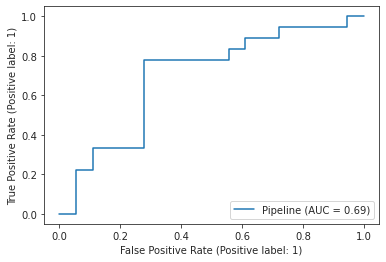

ROC AUC: 0.6944444444444444
confusion matrix:
[[13  5]
 [11  7]]


In [255]:
test_roc = plot_roc_curve(clf_pipe2, X_atest_nohrabx,cr_y_test_nohrabx  )
plt.show()

print('ROC AUC:',str(test_roc.roc_auc))
print('confusion matrix:')
print(confusion_matrix(cr_y_test_nohrabx, clf_pipe2.predict(X_atest_nohrabx)))

roc_test = pd.DataFrame(dtype=np.float64)
roc_test['FPR'] = test_roc.fpr
roc_test['TPR'] = test_roc.tpr
roc_test['auc'] = str(test_roc.roc_auc)

nohrabx_roc_df = pd.DataFrame([roc_test['FPR'],roc_test['TPR']]).T
nohrabx_roc_df.to_csv('./deterministic_results/CR180_noHighRiskABX_elasticnet_test_roc_curve.csv', index=False)